In [1]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    ExpSineSquared,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# log space
points = get_points('../data/points_train.csv')
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points['wait'] = points['wait'].apply(lambda x: 0.1 if x == 0 else x)
region = 'world'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

In [3]:
# parameters to optimize

sigma = stdv

rbf = RBF(
    length_scale=5e4, length_scale_bounds=(8e4,3e5)
)  # using anisotripic kernel (different length scales for each dimension)
rbf2 = RBF(
    length_scale=1e5, length_scale_bounds=(3e5,7e5)
)  # using anisotripic kernel (different length scales for each dimension)
rbf3 = RBF(
    length_scale=5e5, length_scale_bounds=(7e5,3e6)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
    + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print(
    (
        mean_squared_error(points["wait"], points["pred"]),
        root_mean_squared_error(points["wait"], points["pred"]),
        mean_absolute_error(points["wait"], points["pred"]),
    )
)

# validation error
val = get_points("../data/points_val.csv")
val, polygon, map_boundary = get_points_in_region(val, region)
val["lat"] = val.geometry.y
val["lon"] = val.geometry.x

val["pred"], val["std"] = gp.predict(val[["lat", "lon"]].values, return_std=True)
val["pred"] = np.exp(val["pred"] + average)

print(
    (
        mean_squared_error(val["wait"], val["pred"]),
        root_mean_squared_error(val["wait"], val["pred"]),
        mean_absolute_error(val["wait"], val["pred"]),
    )
)

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 80000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 3000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.33**2 * RBF(length_scale=8e+04) + 0.297**2 * RBF(length_scale=6.24e+05) + 0.263**2 * RBF(length_scale=3e+06) + WhiteKernel(noise_level=1.11) [1.08710256e-01 8.00000000e+04 8.84046208e-02 6.24494852e+05
 6.91089923e-02 3.00000000e+06 1.10638459e+00]
(4918.810949204424, 70.13423521508183, 25.642305014192498)
(4370.563964314953, 66.11024099422838, 26.29534157103234)


100%|██████████| 720/720 [13:33<00:00,  1.13s/it]


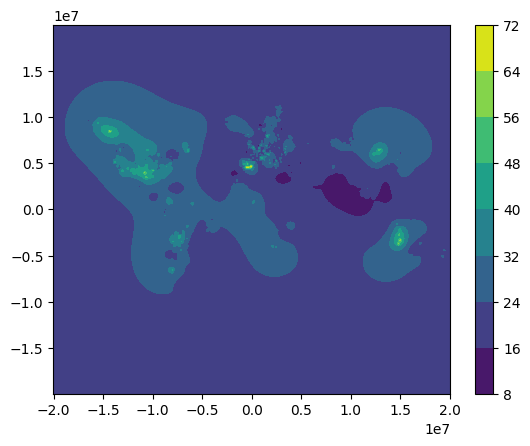

In [4]:
# draw map
resolution = 2

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

map_path = f'intermediate/map_gp_{region}.tif'
save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)

# TODO: we cannot prevent the learned function to not go really high
# (this might especially happen outside the range of the seen data)
map = np.clip(map, 0, 400)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()


In [5]:
save_numpy_map(map, region=region, method="gp", resolution=resolution)
save_numpy_map(certainty_map, region=region, method="gp", kind_of_map='certainty', resolution=resolution)

In [6]:
build_map(
    method="gp",
    resolution=2,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon
)

Loading country shapes...
Transforming heatmap...
max map waiting time: 67.14528132180715
min map waiting time: 8.186801453254681
Plotting heatmap...
max waiting time: 1440.1
[8.186801453254681, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/hpi/fs00/home/till.wenke/hitchmap-data/visualization/predictors/map_utils.py:325: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")
